# Рекомендательная система фильмов

---
**Цель**: Построить рекомендательную систему, которая будет предлагать пользователю список из *n* самых интересных для него фильмов. 
___
**Задачи**: 

1. Обработать данные.
2. Реализовать систему извлечения пула фильмов из которых будут выбираться *n* самых интересных.
3. Построить алгоритм матричного разложения для предсказания значения оценки.
4. Протестировать модель.
---

## Про датасет

Датасет взят с kaggle (https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset#). Он был собран GroupLens Research Project с сайта **MovieLens**. Он содержит данные о 100,000 рейтингах от 943 пользователей на 1682 фильмах. Также представлена простая демографическая информация о пользователях (возраст, пол, должность, почтовый индекс).

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

## Источники

1. Kaggle (https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset#).
2. Учебник по машинному обучению от ШАДа (https://education.yandex.ru/handbook/ml).

## Метод решения. Структура системы.

&emsp;Для предсказаний рейтинга я собираюсь использовать метод матричной факторизации с Alternate Least Squares (ALS). 

&emsp;Однако, так как задача восстановления всех латентных представлений в матрице 941x1682 довольно затратна и, к тому же так как нам не к чему рассматривать все возможные айтемы, а достаточно каким либо образом выбрать пул, айтемы из которого с наибольшей вероятностью могут понравиться пользователю, я решил добавить шаг извлечения кандидатов. Я буду искать k ближайших пользователей с помощью приближенного метода Hierarchial navigable small world (HNSW). Если мы предполагаем, что "похожим" людям нравятся одни и те же фильмы, с помощью KNN мы получим релевантный пул айтемов. 

&emsp;Но для того, чтобы как то найти расстояние в KNN нам каким-то образом надо представить категориальные фичи пользователей. Так как нет понятного способа рассчитать расстояние между мужчиной и женщиной, или между двумя должностями, я решил использовать обучение представлений на основе Multilayer perceptron (MLP). Считается, что этот метод умеет хорошо приближать скрытые зависимости в данных. 

&emsp;В итоге получается структура схематично изображенная на рисунке ниже.  

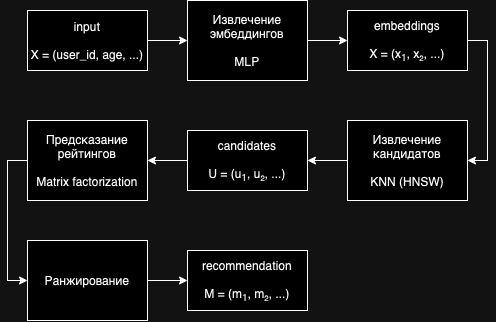

## Embedding retrieving